In [1]:
import pdb

import numpy as np
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats

import emcee
import radvel

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
data = pd.read_csv('legacy_tables/system_props_719.csv')

In [3]:
data.query('name == "95735"').Mstar

461    0.590434
Name: Mstar, dtype: float64

In [4]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/legacy_analysis/legacy_tables/legacy_specmatch_medians.csv')

In [5]:
len(specmatch)

745

In [6]:
masses_only = pd.read_csv('legacy_tables/planet_list_719.csv')

## Sort the planets into real, new candidates, known.

In [7]:
#masses_real = masses_real.loc[masses_real.status != 'B'].reset_index(drop=True)

masses_real = masses_only.query('status != "N" and status != "A"').reset_index(drop=True)
masses_good = masses_real.query('mass != "nan"').reset_index(drop=True)#[masses_only.hostname != 'hip63510']
masses_s = masses_good.query('status == "S" or status == "SS"').reset_index(drop=True)
masses_planet = masses_good.query('status != "S" and status != "SS"').reset_index(drop=True)
masses_old  = masses_planet.query('status == "K"').reset_index(drop=True)
masses_new  = masses_planet.query('status == "C" or status == "J"').reset_index(drop=True)

In [12]:
masses_only.query('hostname == "26161"')#[['axis_minus', 'axis_med', 'axis_plus']]

,Unnamed: 0,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,per_minus,per_plus,k,k_med,k_minus,k_plus,e,e_med,e_minus,e_plus
160,160,26161,J,4.672,4.672,4.041,5.719,14.94,14.94,11.75,...,14105.0,28702.0,47.63,50.034,45.619,57.559,0.74,0.7534,0.709,0.8066


In [9]:
mass = masses_good.mass
mold = masses_old.mass
aold = masses_old.axis
a    = masses_good.axis
perold = masses_old.per
per    = masses_good.per

## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [16]:
merge_columns = list(masses_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

masses_good['name'] = masses_good['hostname']
m_good_spec = pd.merge(masses_good, specmatch, on=['name'])#,suffixes=['_syn','_emp'])

## Take a look at imaging candidates.

In [55]:
imaging_names = ['145675', '111031', '26161', '213472', '203473', '127506', '150554']

In [56]:
imaging_spec = m_good_spec.query('name in ["145675", "111031", "26161", "213472", "203473", "127506", "150554"]')

In [57]:
imaging_spec[['name', 'e_med', 'iso_mass', 'mass', 'mass_minus', 'axis', 'axis_minus', 'axis_med', 'axis_plus', 'iso_logage', 'iso_logage_err1']]

,name,e_med,iso_mass,mass,mass_minus,axis,axis_minus,axis_med,axis_plus,iso_logage,iso_logage_err1
0,145675,0.366356,0.997165,4.910311,4.787921,2.857071,2.816439,2.856997,2.896420,10.022388,0.078579
1,145675,0.465702,0.997165,5.930104,5.341438,15.947416,13.998808,17.505125,23.071287,10.022388,0.078579
17,111031,0.326113,1.144993,12.056604,17.629905,12.811619,17.297921,24.715374,33.583950,9.759124,0.126760
103,213472,0.566000,1.049956,3.299509,2.644000,10.830312,11.110000,13.750000,19.400000,9.913873,0.094715
120,26161,0.753400,1.112582,4.672000,4.041000,14.940000,11.750000,14.940000,19.090000,9.696456,0.116003
220,127506,0.691684,0.722771,35.571482,34.587518,3.370110,3.325292,3.373408,3.421595,9.795882,0.251746


## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (bad measurement).

In [58]:
good_spec_filter = m_good_spec.query('axis < 5 and mass > 0.1 and (status == "K" or status == "C")')#('fe > -0.6 and axis < 5 and mass > 0.1')
print(len(m_good_spec), len(good_spec_filter))
good_spec_filter.sort_values('mass')

235 114


,Unnamed: 0_x,hostname,status,mass,mass_med,mass_minus,mass_plus,axis,axis_med,axis_minus,...,iso_logg_err2,iso_fe,iso_fe_err1,iso_fe_err2,teff_emp,teff_err_emp,radius_emp,radius_err_emp,fe_emp,fe_err_emp
141,193,49674,K,0.117523,0.116499,0.107865,0.125288,0.058043,0.058033,0.057125,...,-0.090726,0.301469,0.061053,-0.061521,5484.0,110.0,1.1040,0.18,0.320,0.09
160,215,75732,K,0.145837,0.143718,0.129989,0.157746,0.796207,0.796004,0.784924,...,-0.094356,0.393148,0.047541,-0.056432,5270.0,110.0,0.9405,0.10,0.475,0.09
128,175,3765,C,0.179048,0.174721,0.154539,0.194935,2.136316,2.123185,2.085791,...,-0.039115,0.169588,0.062326,-0.061180,4997.5,110.0,0.7990,0.10,0.220,0.09
159,213,75732,K,0.179994,0.179062,0.170428,0.187899,0.244238,0.244238,0.240849,...,-0.094356,0.393148,0.047541,-0.056432,5270.0,110.0,0.9405,0.10,0.475,0.09
183,243,97101,C,0.185938,0.184352,0.171917,0.197086,1.402472,1.403789,1.385884,...,-0.019606,-0.106732,0.058717,-0.062085,4124.0,70.0,0.6740,0.10,0.180,0.09
119,158,24040,C,0.204980,0.195566,0.166180,0.225856,1.310851,1.309277,1.274816,...,-0.087648,0.201719,0.058991,-0.059934,5739.0,110.0,1.0680,0.18,0.200,0.09
13,18,107148,K,0.205686,0.201883,0.182254,0.222265,0.371313,0.371341,0.363624,...,-0.091805,0.300231,0.058715,-0.058928,5670.0,110.0,1.0930,0.18,0.310,0.09
10,14,104067,K,0.205722,0.202526,0.184642,0.220515,0.267404,0.267397,0.263929,...,-0.034572,0.090960,0.058770,-0.062778,4931.0,110.0,0.7820,0.10,0.180,0.09
110,143,218566,K,0.211133,0.208114,0.186498,0.229640,0.688686,0.688632,0.680422,...,-0.036478,0.300881,0.061326,-0.061290,4771.0,110.0,0.9480,0.10,0.140,0.09
127,173,3651,K,0.221911,0.221324,0.214283,0.228435,0.295929,0.295926,0.292052,...,-0.055396,0.175240,0.061648,-0.062044,5079.0,110.0,0.9520,0.10,0.200,0.09


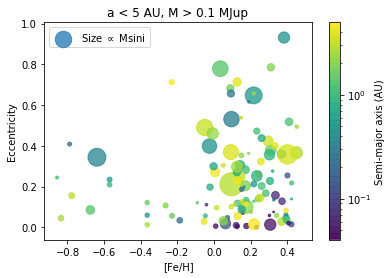

In [59]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.1 MJup')
im = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(30*good_spec_filter.mass), 
                c=good_spec_filter.axis, norm=matplotlib.colors.LogNorm(), alpha=0.75, label=r'Size $\propto$ Msini')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
#ax.set_xlim([-0.3, 0.5])
ax.legend(loc=0)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Semi-major axis (AU)')#, rotation=270)
fig.savefig('planet_candidates/fe_eccentricity_m05.pdf')

## Look at low-metallicity host stars.

In [26]:
good_spec_filter.query('fe < -0.1')[['hostname', 'per', 'mass', 'iso_mass', 
                                     'teff_emp', 'fe', 'fe_emp', 'e']]

,hostname,per,mass,iso_mass,teff_emp,fe,fe_emp,e
4,155358,194.487979,0.813886,0.800707,5979.0,-0.569934,-0.490,0.234480
5,155358,389.028569,0.677862,0.800707,5979.0,-0.569934,-0.490,0.209267
20,114729,1133.062154,0.867743,0.894359,5713.0,-0.264197,-0.325,0.107211
21,114762,83.917559,10.656444,0.781907,6010.0,-0.639222,-0.490,0.343935
41,136925,4363.647716,0.945799,0.865400,5647.0,-0.230876,-0.450,0.712327
50,143761,39.843480,1.048202,0.899121,5666.0,-0.187020,-0.300,0.034234
138,4208,830.839988,0.775791,0.839514,5611.5,-0.228754,-0.375,0.056340
212,gl317,694.459708,2.430120,0.681177,3393.5,-0.675216,0.245,0.085303
215,hip109388,1940.683973,1.030342,0.625679,3514.0,-0.835325,0.430,0.044826
217,hip22627,2334.874241,1.163253,0.661011,3350.5,-0.776834,0.145,0.155343


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

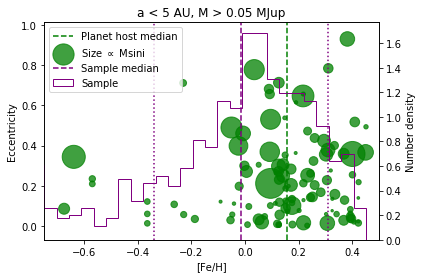

In [260]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='g', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])

ax2 = ax.twinx()
ln3 = ax2.hist(specmatch.fe, bins=50, histtype='step', color='purple', density=True, label='Sample')
median_sample_fe = np.median(specmatch.fe)
#mad_sample_fe = astrostats.median_absolute_deviation(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')
#ax2.set_xlim([-0.75, 0.5])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)

fig.savefig('planet_candidates/fe_eccentricity_hist.pdf')

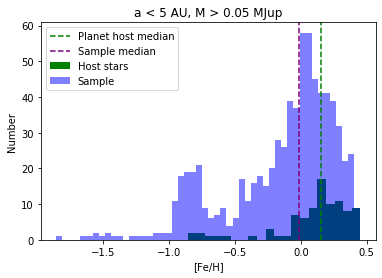

In [261]:
fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.05 MJup')

# Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)

ln1 = ax.hist(unique_fe, bins=20, histtype='stepfilled', color='green', 
              alpha=1, density=False, label='Host stars')
ln2 = ax.axvline(x=median_fe, c='green', ls='--', label='Planet host median')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Number')

ln3 = ax.hist(specmatch.fe, bins=50, histtype='stepfilled', color='blue', 
               alpha=0.5, density=False, label='Sample')
median_sample_fe = np.median(specmatch.fe)
mad_sample_fe = astrostats.mad_std(specmatch.fe)
ln4 = ax.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample median')

lines, labels = ax.get_legend_handles_labels()
ax.legend()

fig.savefig('planet_candidates/fe_two_hist_num.pdf')

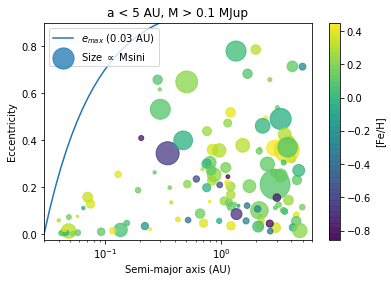

In [54]:
# Overplot peri-distance limit 0.03 AU.
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes

fig, ax = plt.subplots()
plt.title('a < 5 AU, M > 0.1 MJup')
im = ax.scatter(good_spec_filter.axis, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03,6])
ax.set_ylim([-0.025,0.9])
ax.set_xscale('log')
ax.legend(loc=2)
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('[Fe/H]')#, rotation=270)
fig.savefig('planet_candidates/axis_eccentricity_log_lim.pdf')

# Explore the population's eccentricity distribution.

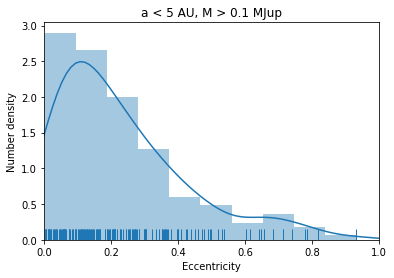

In [60]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('a < 5 AU, M > 0.1 MJup')
ax.set_xlim([0,1])
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_05.pdf')

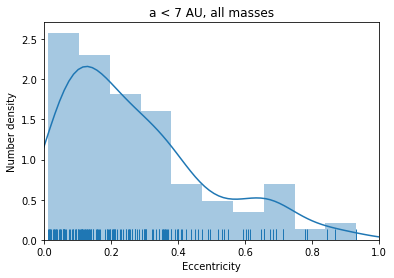

In [61]:
good_spec_all_mass = m_good_spec.query('axis < 7 and axis > 0.1')

ax = sns.distplot(good_spec_all_mass.e, bins=10, rug=True)
#ax.barplot()
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('a < 7 AU, all masses')
ax.set_xlim([0,1])
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_all_masses.pdf')

## Fit Beta distribution to eccentricities. Define a likelihood function for the Beta distribution.

In [25]:
def beta(x, a, b):
    return spec.gamma(a+b)/(spec.gamma(a)*spec.gamma(b)) * x**(a-1) * (1-x)**(b-1)

def lnbetalike(theta, x, y, yerr):
    a, b = theta
    return -0.5*np.sum((y-beta(x, a, b))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

nll = lambda *args: -lnbetalike(*args)
# Kipping: a=0.867, b=3.03
def fit_beta(x, y, yerr, a_init=0.867, b_init=3.03): # Kipping estimates
    fit = op.minimize(nll, [a_init, b_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [ ]:
e_pdf = np.histogram(masses_planet.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_planet.e, range=[0.001,1], density=False)
print(e_pdf[0])

In [134]:
#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[1.09233944 3.70026307]


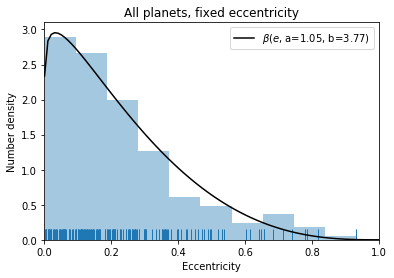

In [135]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit.
es = np.linspace(0.001, 1, num=100)
betas_fit = beta(es, fit[0], fit[1])
ax.plot(es, betas_fit, label=r'$\beta(e$, a=1.05, b=3.77)', c='black')
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_fit_719.pdf')

## Explore Beta distribution posterior. NOT redrawing e's from posterior.

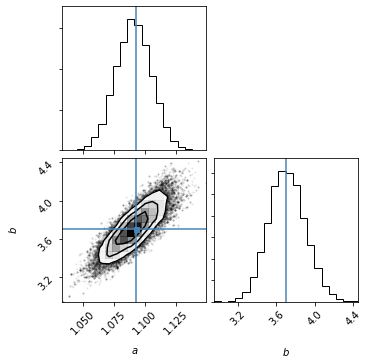

In [136]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnbetalike, args=(e_pdf[1][:-1], e_pdf[0], yerr,))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$"],
                      truths=[fit[0], fit[1]])
fig.savefig("beta.pdf")

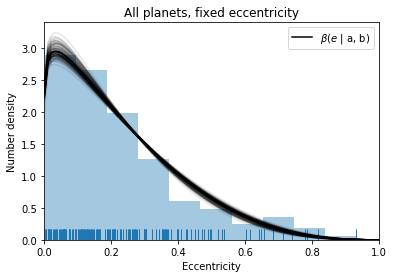

In [138]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, betas_fit, label=r'$\beta(e$ | a, b)', color='black')
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_beta_post_719.pdf')

## Repeat for half-Gaussian distribution.

In [124]:
def gauss(x, sig): # Defined for x >= 0 .
    return 2*np.exp(-(x/sig)**2)/np.sqrt(2*np.pi*sig**2)

def lngausslike(sig, x, y, yerr):
    return -0.5*np.sum((y-gauss(x, sig))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

ngll = lambda *args: -lngausslike(*args)
def fit_gauss(x, y, yerr, sig_init=0.2): # Who knows?
    fit = op.minimize(ngll, [sig_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [126]:
#ygerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
ygerr = 0.1*np.ones(10)
fitg = fit_gauss(e_pdf[1][:-1], e_pdf[0], yerr, sig_init=0.33)
print(fitg)

Optimization terminated successfully.
         Current function value: 13.878099
         Iterations: 2
         Function evaluations: 107
0.33407355268577765


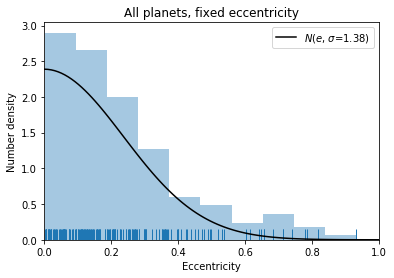

In [127]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit.
es = np.linspace(0.001, 1, num=100)
gausses_fit = gauss(es, fitg)
ax.plot(es, gausses_fit, label=r'$N(e$, $\sigma$=1.38)', c='black')
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_fit_719.pdf')

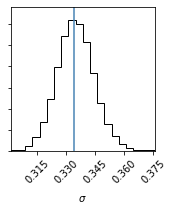

In [128]:
ndim, nwalkers = 1, 100
pos = [fitg + 5*1e-2*np.random.randn(ndim) for i in range(nwalkers)] 

samplerg = emcee.EnsembleSampler(nwalkers, ndim, lngausslike, args=(e_pdf[1][:-1], e_pdf[0], yerr))
samplerg.run_mcmc(pos, 500)

samplesg = samplerg.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samplesg, labels=[r'$\sigma$'],
                      truths=[fitg])
fig.savefig("gauss.pdf")

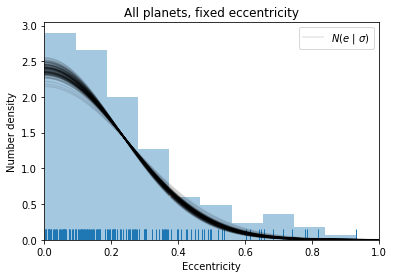

In [130]:
ax = sns.distplot(masses_planet.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Gaussian fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
ax.plot(es, gausses_fit, label=r'$N(e\ |\ \sigma$)', alpha=0.1, c='black')
for sig in samplesg[np.random.randint(len(samplesg), size=100)]:
    gausses = gauss(es, sig)
    ax.plot(es, gausses, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('planet_candidates/eccentricity_histogram_gauss_post_719.pdf')

## Test hierarchical inference. Use Legacy catalog eccentricities & median uncertainties, but simulate bound Gaussian posteriors.

In [411]:
masses_planet.columns

Index(['Unnamed: 0', 'hostname', 'status', 'mass', 'mass_med', 'mass_minus',
       'mass_plus', 'axis', 'axis_med', 'axis_minus', 'axis_plus', 'per',
       'per_med', 'per_minus', 'per_plus', 'k', 'k_med', 'k_minus', 'k_plus',
       'e', 'e_med', 'e_minus', 'e_plus'],
      dtype='object')

In [46]:
def bound(array):
    return np.random.choice(array[(array > 0) & (array < 1)], 100)

# Generate a population, synthetic posteriors, based on real MAP values and CIs. 
masses_noncirc = masses_planet.query('axis > 0.1')
e_minus = np.array(masses_noncirc.e_minus)
e_plus = np.array(masses_noncirc.e_plus)

posts = []
for i, e in enumerate(masses_noncirc.e):
    sig_e = 0.5*(e_plus[i] - e_minus[i])
    posts.append(bound(sig_e*np.random.randn(1000) + e))
posts = np.array(posts)

In [19]:
posts.shape

(151, 100)

In [30]:
# Define the population likelihood for the beta distribution. Can generalize later.
def popprob(samples, a, b):
    K = len(samples)    # Number of planets
    N = len(samples[0]) # Number of posterior samples
    
    sums = []
    for sample in samples:
        probs = beta(sample, a, b)
        sums.append(np.sum(probs)/N)
    return np.prod(sums)

def lnpoplike(theta, samples):
    a, b = theta
    return np.log(popprob(samples, a, b))

def lnpopprior(theta):
    a, b = theta
    if 0 < a < 2 and 1 < b < 15:
        return 0.0
    return -np.inf

def lnpopprob(theta, samples):
    lp = lnpopprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnpoplike(theta, samples)

In [31]:
print(popprob(posts, fit[0], fit[1]))
print(lnpopprob([fit[0], fit[1]], posts))

1.1585317142973992e+25
57.7117807646774


In [38]:
e_pdf = np.histogram(masses_noncirc.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_noncirc.e, range=[0.001,1], density=False)

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) # Poisson uncertainty
yerr = 0.1*np.ones(10)
fit_noncirc = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit_noncirc)

[1.09233944 3.70026307]


## Try sampling!

In [33]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts,))
sampler.run_mcmc(pos, 1000)

(array([[1.07252305, 3.46313099],
        [1.05898242, 3.64023374],
        [1.25217669, 3.41062695],
        [0.99201204, 2.45842317],
        [0.89832068, 2.63133543],
        [0.87594852, 2.69366334],
        [0.9193024 , 2.5862768 ],
        [0.93358815, 3.28430859],
        [1.08979472, 3.1956423 ],
        [1.06269958, 3.85288741],
        [0.88767097, 2.89701787],
        [1.28108773, 3.03466385],
        [0.84373547, 2.94465267],
        [0.97068119, 2.98584047],
        [0.93700642, 2.89130162],
        [0.910383  , 3.1591067 ],
        [1.07191164, 3.14712872],
        [0.75612501, 2.4254233 ],
        [1.09623276, 3.29334149],
        [1.24364157, 3.62595311],
        [1.01437661, 2.43719385],
        [0.99832339, 3.00897555],
        [0.94625405, 2.72720059],
        [1.01412756, 3.40543247],
        [1.18260052, 3.63484   ],
        [0.99326183, 2.62147133],
        [1.12740478, 3.52633548],
        [1.13268907, 3.54141145],
        [0.97522512, 2.37558486],
        [0.974

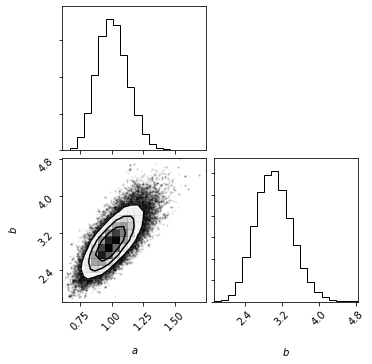

In [116]:
samples = sampler.chain[:, 20:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_all_median = np.median(samples[:, 0])
b_all_median = np.median(samples[:, 1])

fig = corner.corner(samples, labels=["$a$", "$b$"])#, truths=[fit_noncirc[0], fit_noncirc[1]])
fig.savefig("analysis_plots/corner_pop.pdf")

In [40]:
np.percentile(samples, [16, 50, 84], axis=0)

array([[0.88514987, 2.63480096],
       [1.00114476, 3.00934956],
       [1.12895945, 3.422142  ]])

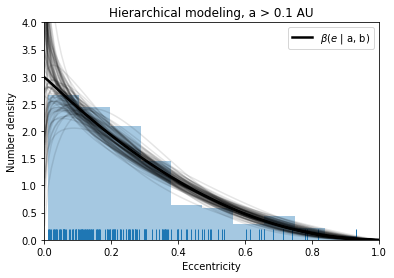

In [122]:
ax = sns.distplot(masses_noncirc.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Hierarchical modeling, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_all_median = beta(es, a_all_median, b_all_median)

ax.plot(es, beta_all_median, label=r'$\beta(e$ | a, b)', color='black', linewidth=2.5)
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_whole_719.pdf')#analysis_plots/

## Separate the (observed) singles and multis. Need to add nplanets to the dataframe first.

In [71]:
names = np.unique(masses_noncirc.hostname)
nplanets = np.array(masses_noncirc.groupby('hostname').count()['status'])
db_nplanets = pd.DataFrame({'hostname':names, 'nplanets':nplanets})

masses_noncirc = pd.merge(masses_noncirc, db_nplanets, on='hostname').reset_index()

In [76]:
masses_single = masses_noncirc.query('nplanets == 1').reset_index()
masses_multi  = masses_noncirc.query('nplanets != 1').reset_index()

posts_single = []
for i, e in enumerate(masses_single.e):
    sig_e = 0.5*(masses_single.e_plus[i] - masses_single.e_minus[i])
    posts_single.append(bound(sig_e*np.random.randn(1000) + e))
posts_single = np.array(posts_single)

posts_multi  = []
for i, e in enumerate(masses_multi.e):
    sig_e = 0.5*(masses_multi.e_plus[i] - masses_multi.e_minus[i])
    posts_multi.append(bound(sig_e*np.random.randn(1000) + e))
posts_multi = np.array(posts_multi)

In [77]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts_single,))
sampler_single.run_mcmc(pos, 1000)

(array([[1.08618718, 2.36710806],
        [1.21110943, 2.6229293 ],
        [0.8095876 , 2.22333403],
        [0.97284268, 2.32851036],
        [1.18895249, 2.53512688],
        [1.11942296, 2.36888134],
        [0.84378662, 2.12289434],
        [0.91403091, 2.50072065],
        [1.29795159, 3.47900463],
        [1.00550138, 1.89042887],
        [0.95306337, 2.2873013 ],
        [0.95123844, 2.19707114],
        [0.95745319, 2.08454979],
        [1.02819443, 2.1639134 ],
        [1.00417552, 2.54651348],
        [1.19209075, 2.81377185],
        [0.96535927, 2.56391999],
        [0.91836314, 2.32109763],
        [0.87760821, 1.97646014],
        [0.75346772, 1.72963307],
        [0.99164791, 2.13156546],
        [1.16998856, 2.14763378],
        [1.0110757 , 1.90264096],
        [1.05024602, 2.31355141],
        [0.84549318, 3.04547508],
        [1.06350011, 2.17998314],
        [1.11157089, 2.69730951],
        [1.00882738, 2.58692527],
        [0.88319827, 2.41234726],
        [1.007

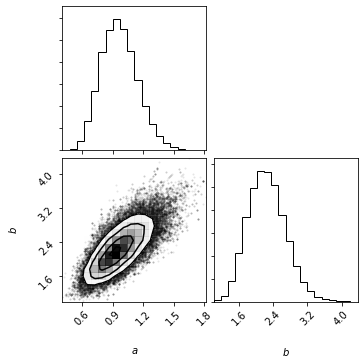

In [83]:
samples_single = sampler_single.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_single_median = np.median(samples_single[:, 0])
b_single_median = np.median(samples_single[:, 1])

fig = corner.corner(samples_single, labels=["$a$", "$b$"])#, truths=[fit_noncirc[0], fit_noncirc[1]])
fig.savefig("analysis_plots/corner_pop_single.pdf")

In [139]:
np.percentile(samples_single, [16, 50, 84], axis=0)

array([[0.7858685 , 1.81115163],
       [0.95424564, 2.22402813],
       [1.14456904, 2.67841393]])

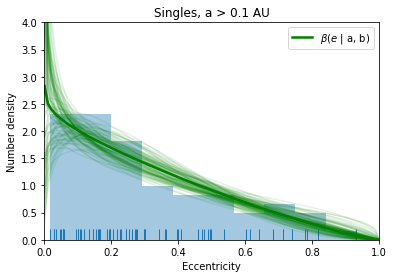

In [120]:
ax = sns.distplot(masses_single.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Singles, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_single_median = beta(es, a_single_median, b_single_median)

ax.plot(es, beta_single_median, label=r'$\beta(e$ | a, b)', color='g', linewidth=2.5)
for a, b in samples_single[np.random.randint(len(samples_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_singles_719.pdf')

In [82]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, args=(posts_multi,))
sampler_multi.run_mcmc(pos, 1000)

(array([[1.07825139, 4.2785678 ],
        [1.23699876, 4.44459204],
        [0.6540701 , 2.55369427],
        [1.05011174, 4.83808296],
        [0.99900618, 4.36523354],
        [0.97310513, 4.54770017],
        [1.31909376, 6.11443247],
        [1.62063896, 6.33225059],
        [1.30397038, 4.88241158],
        [1.62698363, 7.85129147],
        [1.78708983, 7.79054939],
        [0.94576258, 3.60589716],
        [1.28027897, 4.81285554],
        [1.12119613, 4.86976106],
        [1.11234924, 4.880202  ],
        [1.0659167 , 4.97879506],
        [1.50219172, 5.53269056],
        [1.53186768, 6.69287729],
        [1.68636756, 7.19535379],
        [1.55301901, 5.0718731 ],
        [1.4523751 , 5.71320361],
        [1.12953276, 4.18427616],
        [1.52376036, 6.62217685],
        [1.1217592 , 4.79396719],
        [1.23921994, 4.54131297],
        [1.22742984, 4.32787896],
        [1.47644504, 6.46216983],
        [1.42548207, 5.63654766],
        [1.54224441, 5.80062595],
        [1.030

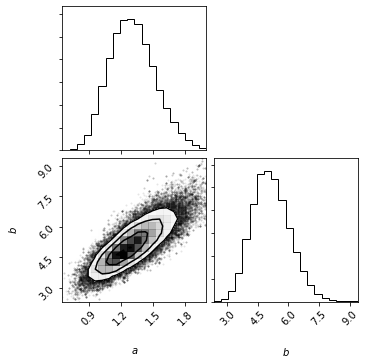

In [101]:
samples_multi = sampler_multi.chain[:, 50:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_single)
a_multi_median = np.median(samples_multi[:, 0])
b_multi_median = np.median(samples_multi[:, 1])

fig = corner.corner(samples_multi, labels=["$a$", "$b$"])
fig.savefig("analysis_plots/corner_pop_multi.pdf")

In [140]:
np.percentile(samples_multi, [16, 50, 84], axis=0)

array([[1.09490751, 4.23680643],
       [1.29840246, 5.08099053],
       [1.52341694, 6.0584008 ]])

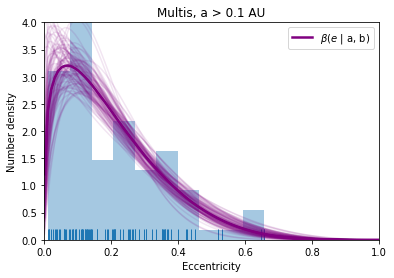

In [112]:
ax = sns.distplot(masses_multi.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Multis, a > 0.1 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_multi_median = beta(es, a_multi_median, b_multi_median)
ax.plot(es, beta_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_multi[np.random.randint(len(samples_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_beta_multis_719.pdf')

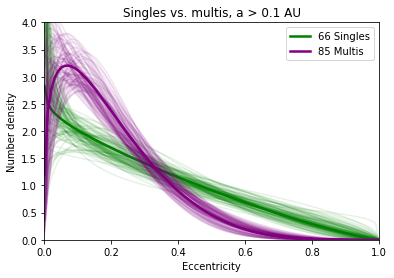

In [114]:
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('Singles vs. multis, a > 0.1 AU')

nsingles = len(masses_single)
nmultis  = len(masses_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_single_median = beta(es, a_single_median, b_single_median)
ax.plot(es, beta_single_median, label='{} Singles'.format(nsingles), color='green', linewidth=2.5)
for a, b in samples_single[np.random.randint(len(samples_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_multi_median = beta(es, a_multi_median, b_multi_median)
ax.plot(es, beta_multi_median, label='{} Multis'.format(nmultis), color='purple', linewidth=2.5)
for a, b in samples_multi[np.random.randint(len(samples_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend()
fig.savefig('analysis_plots/eccentricity_pop_comparison_beta_719.pdf')

## Make observational stats histograms.

In [14]:
obs_stats = pd.read_csv('legacy_tables/observation_stats.csv')
obs_stats = obs_stats.query('baseline > 2922 and Nobs > 17')
obs_stats.columns

Index(['Unnamed: 0', 'Nobs', 'Nobs_CORAVEL', 'Nobs_apf', 'Nobs_j', 'Nobs_k',
       'Nobs_lick', 'Nobs_mcdonald', 'baseline', 'baseline_CORAVEL',
       'baseline_apf', 'baseline_j', 'baseline_k', 'baseline_lick',
       'baseline_mcdonald', 'med_err_CORAVEL', 'med_err_apf', 'med_err_j',
       'med_err_k', 'med_err_lick', 'med_err_mcdonald', 'name'],
      dtype='object')

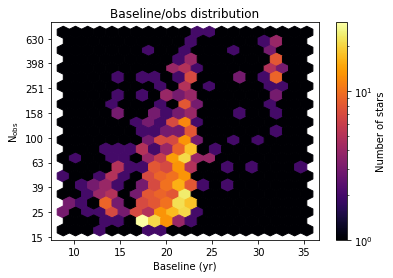

In [45]:
fig, ax = plt.subplots()
hb = ax.hexbin(obs_stats.baseline/365.25, np.log10(obs_stats.Nobs), 
               gridsize=20, bins='log', cmap='inferno')
ax.set_title("Baseline/obs distribution")
ax.set_xlabel('Baseline (yr)')
ax.set_ylabel(r'N$_\mathrm{obs}$')
#ax.set_ylabel(r'log$_{10}$(N$_\mathrm{obs}$)')

# Manually set Nobs logarithmic tick marks.
def format_fn(tick_val, tick_pos):
    return str(int(10**tick_val))

#ax.locator_params(axis='y', nbins=1)
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of stars')
fig.savefig('legacy_tables/hist_base_nobs_2D.pdf')

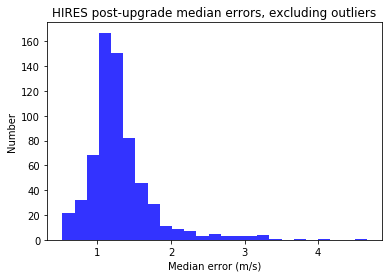

In [162]:
fig, ax = plt.subplots()
ax.hist(obs_stats.query('med_err_j < 5').med_err_j, bins=25, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('HIRES post-upgrade median errors, excluding outliers')
fig.savefig('legacy_tables/hist_HIRES_post_err.pdf')

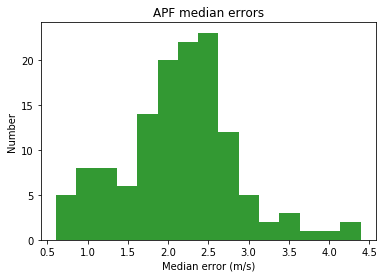

In [168]:
fig, ax = plt.subplots() #.query('med_err_j < 5')
ax.hist(obs_stats.med_err_apf, bins=15, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Median error (m/s)', ylabel='Number')
ax.set_title('APF median errors')
fig.savefig('legacy_tables/hist_APF_err.pdf')

Text(0.5, 1.0, 'Total baseline distribution')

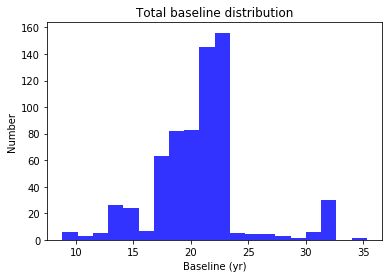

In [178]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline/365.25, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('Total baseline distribution')

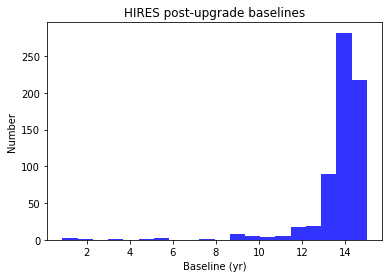

In [179]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_j/365.25, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('HIRES post-upgrade baselines')
fig.savefig('legacy_tables/hist_HIRES_post_base.pdf')

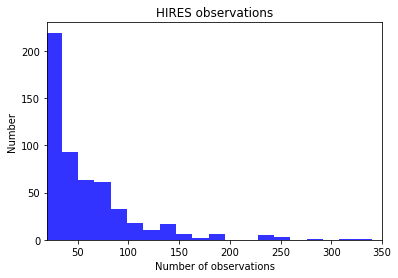

In [180]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_j + obs_stats.Nobs_k, bins=20, histtype='stepfilled', color='blue', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('HIRES observations')
fig.savefig('legacy_tables/hist_HIRES_nobs.pdf')

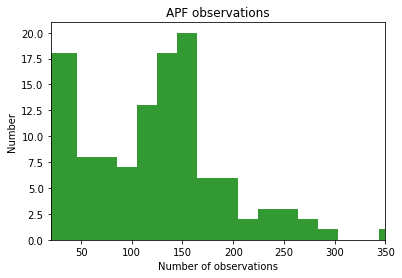

In [143]:
fig, ax = plt.subplots()
ax.hist(obs_stats.Nobs_apf, bins=20, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Number of observations', ylabel='Number')
ax.set_xlim([20,350])
ax.set_title('APF observations')
fig.savefig('legacy_tables/hist_APF_nobs.pdf')

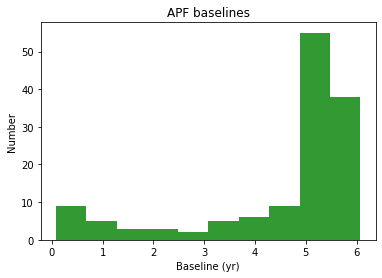

In [145]:
fig, ax = plt.subplots()
ax.hist(obs_stats.baseline_apf/365.25, bins=10, histtype='stepfilled', color='green', 
              alpha=0.8, density=False, label='Host stars')
ax.set(xlabel='Baseline (yr)', ylabel='Number')
ax.set_title('APF baselines')
fig.savefig('legacy_tables/hist_APF_base.pdf')

In [ ]:
axold = sns.distplot(np.log10(mold), rug=True)
axold.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axold.set_title('Known planets')
fig = axold.get_figure()
fig.savefig('planet_candidates/known_histogram.pdf')

In [126]:
masses_close = masses_planet.loc[masses_good.axis < 1]
masses_mid   = masses_planet.loc[np.logical_and(masses_good.axis >= 1, masses_good.axis <= 3)]
masses_far   = masses_planet.loc[masses_good.axis > 3]

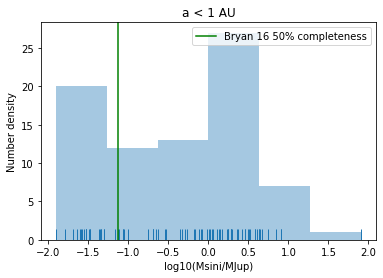

In [142]:
mclose = masses_close.mass
thresh_close = np.log10(0.075) #50% completeness threshold

axclose = sns.distplot(np.log10(mclose), kde=False, rug=True)
axclose.axvline(thresh_close, c='g', label='Bryan 16 50% completeness')
axclose.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axclose.set_title('a < 1 AU')
axclose.legend()

figclose = axclose.get_figure()
figclose.savefig('planet_candidates/close_histogram.pdf')

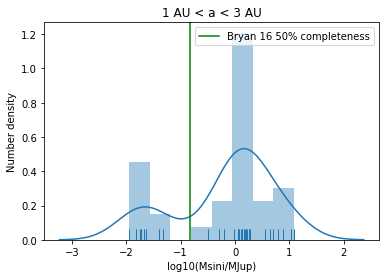

In [128]:
mmid = masses_mid.mass
thresh_mid = np.log10(0.15) #50% completeness threshold

axmid = sns.distplot(np.log10(mmid), rug=True)
axmid.axvline(thresh_mid, c='g', label='Bryan 16 50% completeness')
axmid.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axmid.set_title('1 AU < a < 3 AU')
axmid.legend()

figmid = axmid.get_figure()
figmid.savefig('planet_candidates/middle_histogram.pdf')

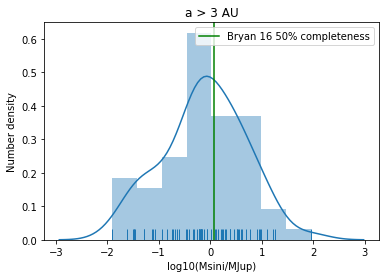

In [129]:
mfar = masses_far.mass
thresh_far = np.log10(1.2) #50% completeness threshold

axfar = sns.distplot(np.log10(mfar), rug=True)
axfar.axvline(thresh_far, c='g', label='Bryan 16 50% completeness')
axfar.set(xlabel='log10(Msini/MJup)', ylabel='Number density')
axfar.set_title('a > 3 AU')
axfar.legend()

figfar = axfar.get_figure()
figfar.savefig('planet_candidates/far_histogram.pdf')

## Make distributions of periods and period ratios.

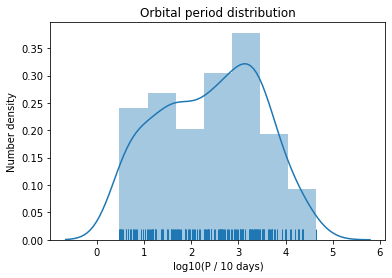

In [137]:
# Only use ratios below 20.
axper = sns.distplot(np.log10(masses_planet.per), rug=True)
axper.set(xlabel='log10(P / 10 days)', ylabel='Number density')
axper.set_title('Orbital period distribution')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_histogram.pdf')

In [133]:
def period_ratios(pers):
    ratios = []
    nplanets = len(pers)
    sorted = np.sort(pers)
    for i in np.arange(nplanets):
        for j in np.arange(i):
            ratios.append(sorted[i]/sorted[j])
    return ratios

In [134]:
systems = masses_planet.hostname.unique()

In [135]:
all_ratios = []
for system in systems:
    sys_db = masses_planet.query('hostname == "{}"'.format(system))#    .loc[masses_planet.hostname == system]
    if len(sys_db) > 1:
        sys_ratios = period_ratios(sys_db.per)
        all_ratios.append(sys_ratios)
all_ratios = np.concatenate(all_ratios)

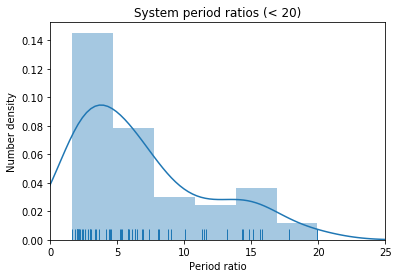

In [136]:
# Only use ratios below 20.
filtered_ratios = np.extract(all_ratios < 20, all_ratios)
axper = sns.distplot(filtered_ratios, rug=True)
axper.set_xlim([0,25])
axper.set(xlabel='Period ratio', ylabel='Number density')
axper.set_title('System period ratios (< 20)')

figper = axper.get_figure()
figper.savefig('planet_candidates/period_ratio_histogram.pdf')

## Catalogue trend systems.

In [ ]:
trends = masses_only.loc[masses_only.per > 5*10**3]
len(trends)